In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
!pip install wordcloud
from wordcloud import WordCloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/00/09/abb305dce85911b8fba382926cfc57f2f257729e25937fdcc63f3a1a67f9/wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/299.9 kB ? eta -:--:--
   ---------- ----------------------------- 81.9/299.9 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 299.9/299.9 kB 3.7 MB/s eta 0:00:00


In [2]:
df = pd.read_csv('Food_Inspections_20250216.csv')

In [3]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1106427,BLOOMING BUD DAYCARE,BLOOMING BUD DAYCARE,2215789.0,Daycare Combo 1586,Risk 1 (High),5715 N LINCOLN AVE,CHICAGO,IL,60659.0,03/07/2013,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.985390,-87.698734,"(41.98538950526786, -87.69873407149943)"
1,2608378,Babas Halal,Babas Halal,2684170.0,Restaurant,Risk 1 (High),7901 S DAMEN AVE,CHICAGO,IL,60620.0,12/03/2024,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)"
2,1106406,FIRST ZABIHA MEAT BAZAAR,FIRST ZABIHA MEAT BAZAAR,2232559.0,Grocery Store,Risk 2 (Medium),2907 W DEVON AVE,CHICAGO,IL,60659.0,02/20/2013,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.997401,-87.702385,"(41.99740137039031, -87.70238538227812)"
3,2609909,HAPPY MARKET,HAPPY MARKET,2912802.0,Grocery Store,Risk 2 (Medium),2334 S WENTWORTH AVE,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)"
4,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400.0,Restaurant,Risk 1 (High),1916 S STATE ST,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)"


In [4]:
df.shape
df.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Results             object
Violations          object
Latitude           float64
Longitude          float64
Location            object
dtype: object

# Convert zip into categorical type

In [5]:
df['Zip'] = df['Zip'].astype(str)

# Assess data missing

In [6]:
#After conversion to object, null values will be converted to nan. Remove the nan so isnull function is still correct
df["Zip"] = df["Zip"].replace("nan", None)

missing_values = df.isnull().sum()
missing_values

Inspection ID          0
DBA Name               0
AKA Name            2426
License #             18
Facility Type       5197
Risk                  88
Address                0
City                 164
State                 58
Zip                   39
Inspection Date        0
Inspection Type        1
Results                0
Violations         79652
Latitude             978
Longitude            978
Location             978
dtype: int64

# Assess Uniqueness 

In [7]:
unique_counts = df.nunique()
print(unique_counts)


Inspection ID      287237
DBA Name            33304
AKA Name            31703
License #           46274
Facility Type         519
Risk                    4
Address             30905
City                   86
State                   6
Zip                   127
Inspection Date      3813
Inspection Type       110
Results                 7
Violations         206183
Latitude            18493
Longitude           18493
Location            18493
dtype: int64


# City

In [8]:
print(df["City"].value_counts())

City
CHICAGO         286102
Chicago            448
chicago            150
CCHICAGO            59
SCHAUMBURG          28
                 ...  
ALGONQUIN            1
GRIFFITH             1
NEW YORK             1
NEW HOLSTEIN         1
GRAYSLAKE            1
Name: count, Length: 86, dtype: int64


In [9]:
#Using k-mean, we need to determine silhouette score to determine the cluster to minimze error rate
df["City"] = df["City"].fillna("")

# Vectorize text (TF-IDF)
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2, 3))
X = vectorizer.fit_transform(df["City"])

For n_clusters = 1, inertia = 816.59
For n_clusters = 2, inertia = 336.42
For n_clusters = 3, inertia = 283.72
For n_clusters = 4, inertia = 257.41
For n_clusters = 5, inertia = 242.59
For n_clusters = 6, inertia = 229.69
For n_clusters = 7, inertia = 214.31
For n_clusters = 8, inertia = 202.16
For n_clusters = 9, inertia = 193.74
For n_clusters = 10, inertia = 183.08
For n_clusters = 11, inertia = 174.49
For n_clusters = 12, inertia = 167.64
For n_clusters = 13, inertia = 157.98
For n_clusters = 14, inertia = 149.29
For n_clusters = 15, inertia = 144.22
For n_clusters = 16, inertia = 136.62
For n_clusters = 17, inertia = 128.84
For n_clusters = 18, inertia = 122.02
For n_clusters = 19, inertia = 117.51
For n_clusters = 20, inertia = 108.95


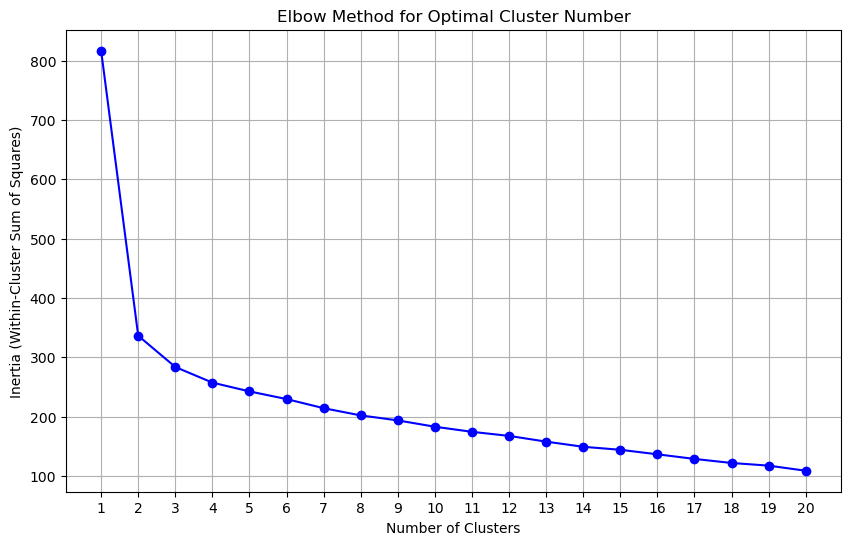

In [13]:
# Determine optimal clusters using elbow method
inertia_values = []
cluster_range = range(1, 21)  # Testing cluster numbers from 1 to 20

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    print(f"For n_clusters = {n_clusters}, inertia = {kmeans.inertia_:.2f}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xticks(cluster_range)  # Ensure x-axis shows every integer increment
plt.grid(True)
plt.show()

In [14]:
# Cluster with K-Means
n_clusters = 6  # Adjust based on unique cities
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# Step 3: Analyze clusters
cluster_summary = df.groupby("Cluster")["City"].agg(["count", lambda x: list(x.unique())])
print(cluster_summary)

          count                                         <lambda_0>
Cluster                                                           
0        286721               [CHICAGO, chicago, Chicago, CHicago]
1           400  [, BROOKFIELD, CHICAGO., EVERGREEN, NAPERVILLE...
2            28                                       [SCHAUMBURG]
3            20                                         [EVANSTON]
4            59                                         [CCHICAGO]
5             9                                         [OAK PARK]


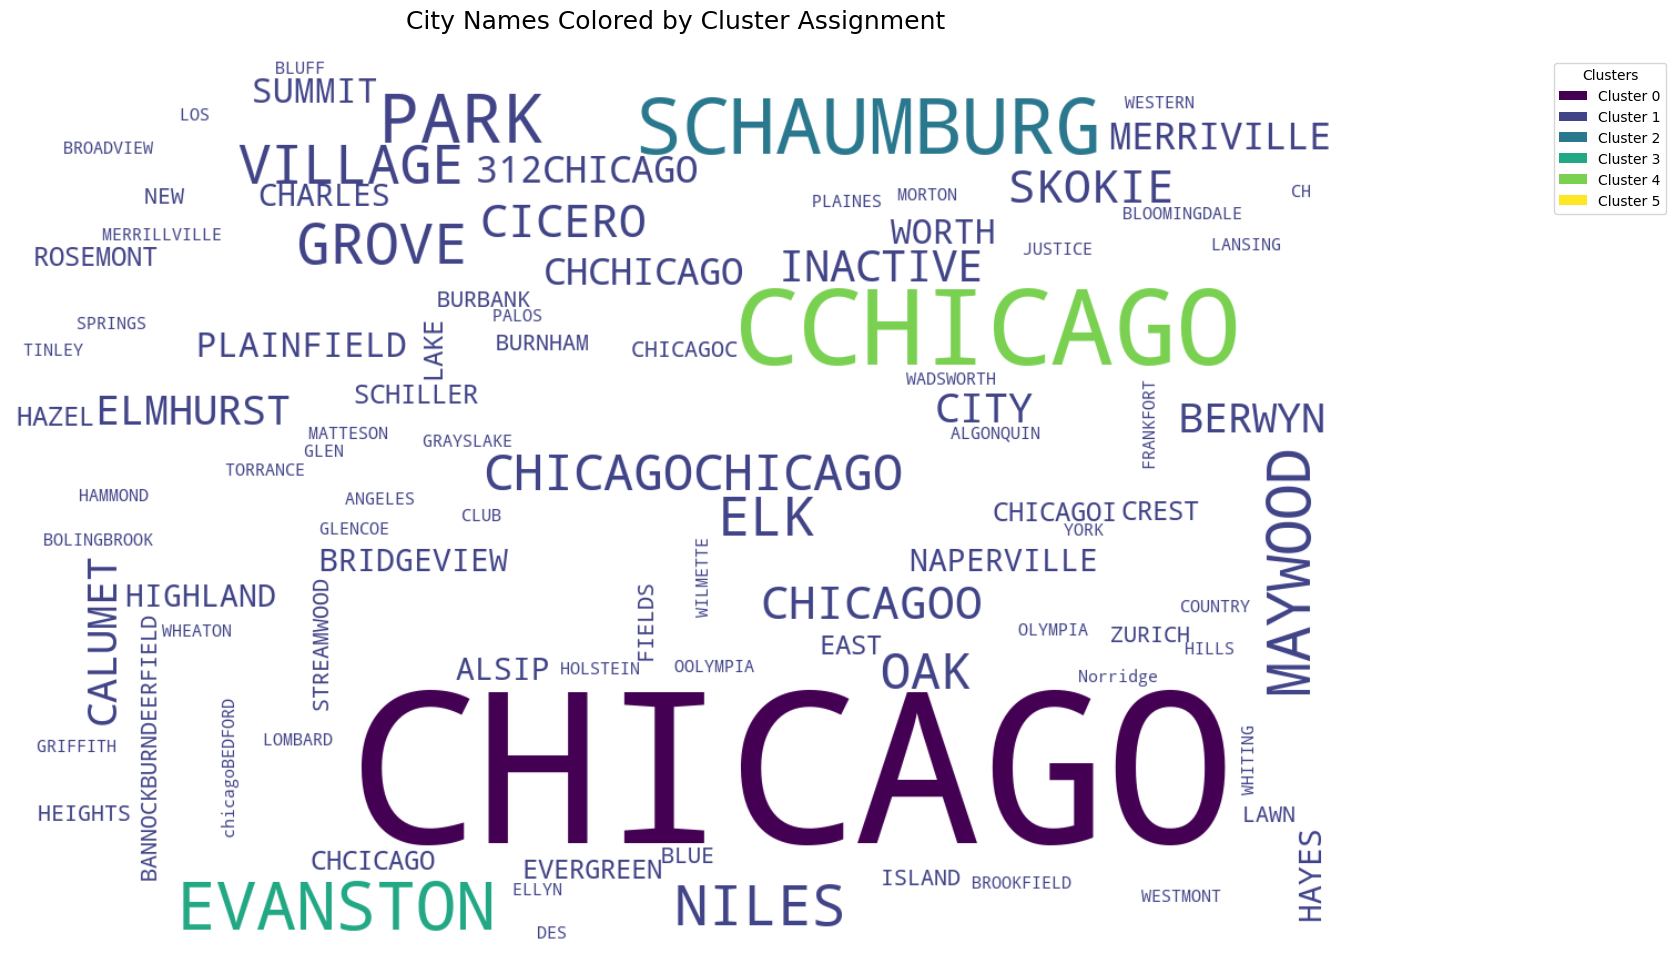

In [19]:
import matplotlib.colors as mcolors

# Prepare the text data with cluster information
def prepare_clustered_text(df):
    cluster_texts = {}
    for cluster in df['Cluster'].unique():
        cities = ' '.join(df[df['Cluster'] == cluster]['City'].tolist())
        cluster_texts[cluster] = cities
    return cluster_texts

# Create a color mapping function based on clusters
def get_cluster_colormap(n_clusters):
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
    return {i: mcolors.rgb2hex(color) for i, color in enumerate(colors)}

# Generate the clustered word cloud
def generate_clustered_wordcloud(df, max_words=200):
    n_clusters = len(df['Cluster'].unique())
    cluster_texts = prepare_clustered_text(df)
    colormap = get_cluster_colormap(n_clusters)
    
    # Combine all text while preserving cluster info
    all_text = []
    color_funcs = []
    for cluster, text in cluster_texts.items():
        words = text.split()
        all_text.extend(words)
        color_funcs.extend([colormap[cluster]] * len(words))
    
    # Create a color function for WordCloud
    def color_func(word, font_size, position, orientation, random_state, **kwargs):
        idx = all_text.index(word) if word in all_text else 0
        return color_funcs[idx]
    
    # Generate the word cloud
    wc = WordCloud(
        width=1200,
        height=800,
        background_color='white',
        max_words=max_words,
        color_func=color_func,
        collocations=False,
        prefer_horizontal=0.9
    ).generate(' '.join(all_text))
    
    # Plot with legend
    plt.figure(figsize=(16, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    
    # Create legend
    legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=colormap[i], 
                       label=f'Cluster {i}') for i in range(n_clusters)]
    plt.legend(handles=legend_elements, 
               loc='upper right', 
               bbox_to_anchor=(1.25, 1),
               title='Clusters')
    
    plt.title('City Names Colored by Cluster Assignment', pad=20, fontsize=18)
    plt.tight_layout()
    plt.show()

# Generate the visualization
generate_clustered_wordcloud(df)

###### 

In [20]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz, process


df['City_Upper'] = df['City'].str.upper()

# Count before cleaning
original_chicago_count = (df['City_Upper'] == 'CHICAGO').sum()
print(f"Count of 'CHICAGO' before cleaning: {original_chicago_count}")

# 2. Fuzzy matching with only CHICAGO as valid city
valid_cities = ['CHICAGO']  # Only CHICAGO is considered valid

def correct_to_chicago(city):
    # Skip if already correct
    if city == 'CHICAGO':
        return city
    
    # Get best match and score
    match, score = process.extractOne(city, valid_cities, scorer=fuzz.ratio)
    
    # Only correct if very high confidence (adjust threshold as needed)
    return match if score >= 85 else city

df['City_Clean'] = df['City_Upper'].apply(correct_to_chicago)

# Count after cleaning
cleaned_chicago_count = (df['City_Clean'] == 'CHICAGO').sum()
print(f"Count of 'CHICAGO' after cleaning: {cleaned_chicago_count}")
print(f"Number of new CHICAGO matches: {cleaned_chicago_count - original_chicago_count}")

# 3. Show transformation details
print("\nDetailed transformations:")
transform_report = df[['City', 'City_Upper', 'City_Clean']].copy()
transform_report['Changed'] = transform_report['City_Upper'] != transform_report['City_Clean']
print(transform_report[transform_report['Changed']])

# Optional: Show fuzzy scores for changed rows
print("\nFuzzy matching scores for changes:")
for original in transform_report[transform_report['Changed']]['City_Upper']:
    score = fuzz.ratio(original, 'CHICAGO')
    print(f"{original} -> CHICAGO (score: {score})")

C:\Users\renal\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


  Obtaining dependency information for fuzzywuzzy from https://files.pythonhosted.org/packages/43/ff/74f23998ad2f93b945c0309f825be92e04e0348e062026998b5eefef4c33/fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata
Count of 'CHICAGO' before cleaning: 286721


Count of 'CHICAGO' after cleaning: 286810
Number of new CHICAGO matches: 89

Detailed transformations:
            City City_Upper City_Clean  Changed
3003    CHICAGO.   CHICAGO.    CHICAGO     True
4510    CCHICAGO   CCHICAGO    CHICAGO     True
11560   CCHICAGO   CCHICAGO    CHICAGO     True
18388   CCHICAGO   CCHICAGO    CHICAGO     True
18435   CHICAGO.   CHICAGO.    CHICAGO     True
...          ...        ...        ...      ...
274223  CCHICAGO   CCHICAGO    CHICAGO     True
279078  CCHICAGO   CCHICAGO    CHICAGO     True
280405  CCHICAGO   CCHICAGO    CHICAGO     True
282389  CCHICAGO   CCHICAGO    CHICAGO     True
282394  CCHICAGO   CCHICAGO    CHICAGO     True

[89 rows x 4 columns]

Fuzzy matching scores for changes:
CHICAGO. -> CHICAGO (score: 93)
CCHICAGO -> CHICAGO (score: 93)
CCHICAGO -> CHICAGO (score: 93)
CCHICAGO -> CHICAGO (score: 93)
CHICAGO. -> CHICAGO (score: 93)
CCHICAGO -> CHICAGO (score: 93)
CCHICAGO -> CHICAGO (score: 93)
CHCHICAGO -> CHICAGO (score: 88)
CCHIC